In [1]:
import cobra
from cobra import Model, Reaction, Metabolite
from thermo_flux.core.metabolite import ThermoMetabolite
import thermo_flux
from thermo_flux.io import load_excel as ex
from thermo_flux.core.model import ThermoModel, ThermoReaction
from equilibrator_api import  Q_
import pandas as pd
from thermo_flux.io import load_gams as gs
from thermo_flux.io import helper_load as hl
from thermo_flux.utils.vis import compare_met
import numpy as np
import gurobipy as  gp
from gurobipy import GRB


import seaborn as sns
import matplotlib.pyplot as plt


Import sbml model from BiGG

In [2]:
from cobra.io import load_json_model
model=load_json_model('iMM904.json')

#set objective to biomass
model.objective = model.reactions.BIOMASS_SC5_notrace
model.reactions.EX_co2_e.id='co2_EX'
model.reactions.EX_o2_e.id='o2_EX'
model.reactions.EX_etoh_e.id='etoh_EX'
model.repair()

for rxn in model.reactions:
    if 'EX_' not in rxn.id:
        rxn.lower_bound=-500 if rxn.lower_bound==-999999.0 else rxn.lower_bound
        rxn.upper_bound=500 if rxn.upper_bound==999999.0 else rxn.upper_bound
    else:
        rxn.lower_bound=-500 if rxn.lower_bound==-999999.0 else rxn.lower_bound
        rxn.upper_bound=500 if rxn.upper_bound==999999.0 else rxn.upper_bound
       # print(rxn.id,rxn.lower_bound,rxn.upper_bound)

#reset O2 exchange bound
model.optimize().to_frame().loc['BIOMASS_SC5_notrace']['fluxes']
model.reactions.o2_EX.bounds=(-500,0)

print(model.optimize().to_frame().loc['BIOMASS_SC5_notrace']['fluxes'])
model.optimize().to_frame().loc[[rxn.id for rxn in model.boundary]]



Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-26
0.9748814206733495


,fluxes,reduced_costs
EX_epistest_SC_e,0.0,-96.275549
EX_epist_e,0.0,-1.676719
EX_ergst_e,0.0,-1.722387
EX_ergstest_SC_e,0.0,-96.321217
EX_13BDglcn_e,0.0,-0.196130
...,...,...
EX_xyl__D_e,0.0,-0.163442
EX_xylt_e,0.0,-0.176421
EX_rib__D_e,0.0,-0.163442
EX_zymst_e,0.0,-1.620476


c:\Users\tedns\anaconda3\envs\thermoflux\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


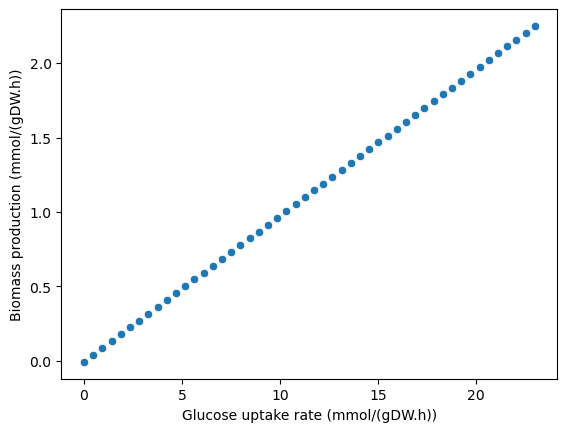

In [3]:
#plot biomass yield for stoichiometric model
#GUR_range=[-0.25, -0.57, -0.6 , -1.1 , -1.67, -2.14, -2.22, -2.83, -3.24, -3.7, -4.67, -5.44, -7.62, -8.09, -8.33, -10.23, -13.18, -15.7, -22.42]
GUR_range = np.linspace(-0, -23, 50)

GUR_plot_range=[-x for x in GUR_range]
biomass_flux=[]
etoh_flux=[]
o2_flux=[]
co2_flux=[]
for GUR in GUR_range:
    model.reactions.EX_glc__D_e.upper_bound=0
    model.reactions.EX_glc__D_e.lower_bound=GUR
    sol = model.optimize()
    #add values to list
    biomass_flux.append(sol.fluxes.loc['BIOMASS_SC5_notrace'])
    etoh_flux.append(sol.fluxes.loc['etoh_EX'])
    o2_flux.append(sol.fluxes.loc['o2_EX'])
    co2_flux.append(sol.fluxes.loc['co2_EX'])
#plot biomass vs GUR in a scatter plot
sns.scatterplot(x=GUR_plot_range,y=biomass_flux)
plt.xlabel('Glucose uptake rate (mmol/(gDW.h))')
plt.ylabel('Biomass production (mmol/(gDW.h))')
fba_flux=pd.DataFrame({'biomass_EX':biomass_flux,'etoh_EX':etoh_flux,'o2_EX':o2_flux,'co2_EX':co2_flux},index=GUR_range)
# plt.savefig('Figures/growth_stoichio_only.png',dpi=300)
# model.optimize().to_frame().loc['BIOMASS_SC5_notrace']/model.optimize().to_frame().loc['EX_glc__D_e']

Step 1 - Physical and Biochemical parameters

In [4]:
tmodel=ThermoModel(model,split_biomass=True, add_charge_exchange= True)

Initializing component contribution object...
No valid license for cxcalc installed, operating in read-only mode. A local cache may be loaded, but no compounds can be created. Please obtain a ChemAxon license to enable compound creation.
Loading compounds from iMM904_compound.sqlite
added reaction:  biomass_ce: biomass_c <=> biomass_e
added reaction:  biomass_EX: biomass_e <=> 
added reaction:  charge_ce: charge_e <=> charge_c
added reaction:  EX_charge: charge_e <=> 
added reaction:  charge_cm: charge_m <=> charge_c
added reaction:  charge_cx: charge_x <=> charge_c
added reaction:  charge_cr: charge_r <=> charge_c
added reaction:  charge_cv: charge_v <=> charge_c
added reaction:  charge_cg: charge_g <=> charge_c
added reaction:  charge_cn: charge_n <=> charge_c


In [5]:
#define the biochemical parameters of the model

tmodel.phi={'ec': Q_(-0.06,'volt'), 'cm': Q_(-0.16,'volt'),'cx':Q_(0,'volt'),'cr':Q_(0,'volt'),'cv':Q_(0,'volt'),'cg':Q_(0,'volt'),'cn':Q_(0,'volt')}
tmodel.pH={'c':Q_(7),'e':Q_(5),'m':Q_(7.4),'r':Q_(7),'v':Q_(5.5),'g':Q_(7),'x':Q_(7),'n':Q_(7)} #On the intracellular pH of baker’s yeast(r), Martinez-Munoz et al. 2008(v), Juan Llopis et al 1998 (g), 7 is default pH

#change max drGcalc_drGt
tmodel._max_drG=Q_(1e6,'kJ/mol') #max is already 1e8 shouldnt need to change


Step 2 - Definition of metabolites

In [6]:
tmodel.get_compounds(search = True)

C:\Users\tedns\AppData\Local\Temp\ipykernel_1896\2562127799.py:1: UserWarning: dolichol_c has inconsistent formula with eQuilibrator identified metabolite. COBRA:{'C': 15, 'H': 28, 'O': 1}, eQuilibrator:{'C': 25, 'O': 1}. Defining as unknown compound
  tmodel.get_compounds(search = True)
C:\Users\tedns\AppData\Local\Temp\ipykernel_1896\2562127799.py:1: UserWarning: dolmanp_r has inconsistent formula with eQuilibrator identified metabolite. COBRA:{'C': 21, 'H': 38, 'O': 9, 'P': 1}, eQuilibrator:{'C': 31, 'O': 9, 'P': 1}. Defining as unknown compound
  tmodel.get_compounds(search = True)
C:\Users\tedns\AppData\Local\Temp\ipykernel_1896\2562127799.py:1: UserWarning: glycogen_c has inconsistent formula with eQuilibrator identified metabolite. COBRA:{'C': 6, 'H': 10, 'O': 5}, eQuilibrator:{'O': 21, 'C': 24}. Defining as unknown compound
  tmodel.get_compounds(search = True)
C:\Users\tedns\AppData\Local\Temp\ipykernel_1896\2562127799.py:1: UserWarning: glycogen_v has inconsistent formula wit

C:\Users\tedns\AppData\Local\Temp\ipykernel_1896\2562127799.py:1: UserWarning: mhpglu_c has inconsistent formula with eQuilibrator identified metabolite. COBRA:{'C': 25, 'H': 36, 'N': 8, 'O': 12}, eQuilibrator:{'C': 30, 'N': 9, 'O': 12}. Defining as unknown compound
  tmodel.get_compounds(search = True)
C:\Users\tedns\AppData\Local\Temp\ipykernel_1896\2562127799.py:1: UserWarning: macchitppdol_g has inconsistent formula with eQuilibrator identified metabolite. COBRA:{'C': 37, 'H': 64, 'N': 2, 'O': 22, 'P': 2}, eQuilibrator:{'C': 47, 'O': 22, 'P': 2, 'N': 2}. Defining as unknown compound
  tmodel.get_compounds(search = True)
C:\Users\tedns\AppData\Local\Temp\ipykernel_1896\2562127799.py:1: UserWarning: hpglu_c has inconsistent formula with eQuilibrator identified metabolite. COBRA:{'C': 24, 'H': 34, 'N': 8, 'O': 12}, eQuilibrator:{'N': 9, 'C': 29, 'O': 12}. Defining as unknown compound
  tmodel.get_compounds(search = True)


C:\Users\tedns\AppData\Local\Temp\ipykernel_1896\2562127799.py:1: UserWarning: trdox_c has inconsistent formula with eQuilibrator identified metabolite. COBRA:{'X': 1}, eQuilibrator:{'N': 4, 'C': 10, 'S': 2, 'O': 4}. Defining as unknown compound
  tmodel.get_compounds(search = True)
C:\Users\tedns\AppData\Local\Temp\ipykernel_1896\2562127799.py:1: UserWarning: trdox_m has inconsistent formula with eQuilibrator identified metabolite. COBRA:{'X': 1}, eQuilibrator:{'N': 4, 'C': 10, 'S': 2, 'O': 4}. Defining as unknown compound
  tmodel.get_compounds(search = True)
C:\Users\tedns\AppData\Local\Temp\ipykernel_1896\2562127799.py:1: UserWarning: trdox_n has inconsistent formula with eQuilibrator identified metabolite. COBRA:{'X': 1}, eQuilibrator:{'N': 4, 'C': 10, 'S': 2, 'O': 4}. Defining as unknown compound
  tmodel.get_compounds(search = True)
C:\Users\tedns\AppData\Local\Temp\ipykernel_1896\2562127799.py:1: UserWarning: trdox_x has inconsistent formula with eQuilibrator identified metabol

[████████████████████████████████████████] 1236/1236 charge_n                                                     



[]

In [7]:
#define biomass parameters 
#if the biomass formula is not automatically calcualted it's important to specifiy the hydrogen atoms in biomass to ensure correct proton balancing 
tmodel.metabolites.biomass_c.formula = 'H67'
tmodel.metabolites.biomass_e.formula = 'H67'

#manually define charge of cytochrome C so electron movement is correctly calcualted
tmodel.metabolites.focytc_m.charge = 2
tmodel.metabolites.focytc_m.redox= True #define as redox metabolite 
tmodel.metabolites.ficytc_m.charge = 3
tmodel.metabolites.ficytc_m.redox = True

### Step 3 - metabolites formation energies

When specifying the value of `dfGprime` for the biomass metabolite, we should plug in the values in units of **J/gDW**. This differs from all the other reactions in the model, for which values of **kJ/mol** are used.

The reason for this discrepancy has to do with the units of the fluxes.

For a normal reaction:
$g_{diss, rxn} = \Delta_rG \times v = (kJ/mol) \times (mmol/gDW/h) = (10^3 J/mol) \times (10^{-3} mol/gDW/h) = J/gDW/h$

For the biomass reaction:
$g_{diss, bio} = \Delta_fG_{bio} \times \mu = (J/gDW) \times (gDW/gDW/h) = J/gDW/h $

Since thermoflux handles all reactions the same when determining the gibbs energy dissipation rate (multiplying $v$ by $\Delta_rG$), we have to **pretend** that the biomass formation energy has units of kJ/mol. E.g:
`tmodel.metabolites.biomass_c.dfGprime = Q_(701.767, "kJ/mol")` (where 701.767 is the formation energy of E.coli biomass at cytosolic pH, in units of J/gDW)

In [8]:
#define biomass properties
tmodel.reactions.BIOMASS_SC5_notrace.id='biomass_c' #update biomass reaction name for convenience

tmodel.metabolites.biomass_c.dfG0 = Q_(-3.04,'kJ/mol')*1000 #From Battley 1991, *1000 for mmol flux units (actual units here are J/gDW)
tmodel.metabolites.biomass_e.dfG0 = Q_(-3.04,'kJ/mol')*1000


### Step 4 - Transporters

In [9]:
#idenfity transporters where the transported metabolite is empty
#these could either be redox reactions or proton pumps just moving electrons (charge) and protons 
#or they could be transporters with chemcial transformation during the transport process
for reaction in tmodel.reactions:
    if len(reaction.compartments) > 1:
        if thermo_flux.tools.drg_tools.calc_transported_mets(reaction) == {}:
            print(reaction.id, reaction, thermo_flux.tools.drg_tools.calc_transported_mets(reaction))


ASPOcm ASPOcm: asp__L_c + fad_m --> fadh2_m + h_c + iasp_c {}
ATPS ATPS: atp_c + h2o_c --> adp_c + h_e + pi_c {}
DHORD4i DHORD4i: dhor__S_c + q6_m --> orot_c + q6h2_m {}
DOLPMTcer DOLPMTcer: dolp_c + gdpmann_c --> dolmanp_r + gdp_c {}
DXHPScm DXHPScm: h2o_c + q6_m + spmd_c --> 13dampp_c + 4abutn_c + q6h2_m {}
D_LACDcm D_LACDcm: 2.0 ficytc_m + lac__D_c --> 2.0 focytc_m + pyr_c {}
FDNG FDNG: for_c + h_c + q6_m --> co2_c + q6h2_m {}
FRDcm FRDcm: fadh2_m + fum_c --> fad_m + succ_c {}
L_LACD2cm L_LACD2cm: 2.0 ficytc_m + lac__L_c --> 2.0 focytc_m + pyr_c {}
NADH2_u6cm NADH2_u6cm: h_c + nadh_c + q6_m --> nad_c + q6h2_m {}


In [10]:
#DOLPMTcer involved chemcial transformation of dolp. We assume transport of dolmanp for thermodynamic calcualtion
tmodel.reactions.DOLPMTcer.transported_mets = {tmodel.metabolites.dolmanp_r: -1}

Step 4 - charge and proton balancing

In [11]:
for rxn in tmodel.reactions:
    thermo_flux.tools.drg_tools.reaction_balance(rxn, balance_charge=True, balance_mg=False)

C:\Users\tedns\AppData\Local\Temp\ipykernel_1896\1541778503.py:2: UserWarning: ATPS3v is not balanced and could not be automatically balanced, please check reaction stoichiometry or define reaction.transported_h
  thermo_flux.tools.drg_tools.reaction_balance(rxn, balance_charge=True, balance_mg=False)


In [12]:
#ATPS3v is vacuolar ATP synthase transporting three protons per ATP
tmodel.reactions.ATPS3v

Reaction identifier,ATPS3v
Name,ATP synthase vacuole
Memory address,0x16d19f17f40
Stoichiometry,adp_v + 3.0 h_c + pi_v --> atp_v + h2o_v + 2.0 h_v ADP C10H12N5O10P2 + 3.0 H+ + Phosphate --> ATP C10H12N5O13P3 + H2O H2O + 2.0 H+
GPR,YBR127C and YDL185W and YEL027W and YEL051W and YGR020C and YHR026W and YHR039C_A and YKL080W and...
Lower bound,0.0
Upper bound,500


In [13]:
tmodel.reactions.ATPS3v.transported_h = {'v': 3.0, 'c': -3.0}
thermo_flux.tools.drg_tools.reaction_balance(tmodel.reactions.ATPS3v, balance_charge=True, balance_mg=False)
tmodel.reactions.ATPS3v

Reaction identifier,ATPS3v
Name,ATP synthase vacuole
Memory address,0x16d19f17f40
Stoichiometry,adp_v + 3.0 charge_c + 3.0 h_c + pi_v --> atp_v + 3.0 charge_v + h2o_v + 3.021815 h_v ADP C10H12N5O10P2 + 3.0 charge + 3.0 H+ + Phosphate --> ATP C10H12N5O13P3 + 3.0 charge + H2O H2O + 3.021815 H+
GPR,YBR127C and YDL185W and YEL027W and YEL051W and YGR020C and YHR026W and YHR039C_A and YKL080W and...
Lower bound,0.0
Upper bound,500


Add thermodynamic constraints and parameters

In [14]:
#change max flux to 500 for all reactions

tmodel.reactions.get_by_id("biomass_EX").bounds = (0,500)
tmodel.reactions.get_by_id("biomass_c").bounds = (0,500)
tmodel.reactions.get_by_id("biomass_ce").bounds = (0,500)


for rxn in tmodel.reactions:
    rxn.lower_bound = -500 if rxn.lower_bound == -1000 else rxn.lower_bound
    rxn.upper_bound = 500 if rxn.upper_bound == 1000 else rxn.upper_bound
tmodel.objective = tmodel.reactions.biomass_EX

In [15]:
tmodel.update_thermo_info(fit_unknown_dfG0=False,search=True)


Identifying compounds...
[████████████████████████████████████████] 1244/1244 Mg_n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

Estimating dfG0'...
ficytc_m 0 kilojoule / mole
focytc_m 0 kilojoule / mole
biomass_c 0 kilojoule / mole
biomass_e 0 kilojoule / mole
[████████████████████████████████████████] 1244/1244 Mg_n     

In [16]:
for met in tmodel.metabolites:
    if met.ignore_conc:
        print(met.id,met.ignore_conc)

h2o_c True
h2o_e True
h2o_g True
h2o_m True
h2o_n True
h2o_r True
h2o_v True
h2o_x True
h_c True
h_e True
h_g True
h_m True
h_n True
h_r True
h_v True
h_x True
oh1_c True
oh1_m True
biomass_c True
biomass_e True
charge_c True
charge_e True
charge_m True
charge_x True
charge_r True
charge_v True
charge_g True
charge_n True


In [17]:
for rxn in tmodel.reactions:
    if rxn.ignore_snd:
        print(rxn.id,rxn.ignore_snd)

EX_epistest_SC_e True
EX_epist_e True
EX_ergst_e True
EX_ergstest_SC_e True
EX_13BDglcn_e True
EX_etha_e True
EX_2hb_e True
etoh_EX True
EX_fe2_e True
EX_fecost_e True
EX_2mbac_e True
EX_2mbald_e True
EX_2mbtoh_e True
EX_2mppal_e True
EX_2phetoh_e True
EX_fecostest_SC_e True
EX_fmn_e True
EX_3c3hmp_e True
EX_3mbald_e True
EX_for_e True
EX_fru_e True
EX_3mop_e True
EX_4abut_e True
EX_fum_e True
EX_g3pc_e True
EX_4abz_e True
EX_5aop_e True
EX_g3pi_e True
EX_gal_e True
EX_8aonn_e True
EX_Nbfortyr_e True
EX_abt_e True
EX_ac_e True
EX_acald_e True
EX_aces_e True
EX_galur_e True
EX_gam6p_e True
EX_gcald_e True
EX_glc__D_e True
EX_gln__L_e True
EX_glu__L_e True
EX_glx_e True
EX_ade_e True
EX_adn_e True
EX_akg_e True
EX_ala__L_e True
EX_gly_e True
EX_glyc_e True
EX_gsn_e True
EX_gthox_e True
EX_gthrd_e True
EX_alltn_e True
EX_alltt_e True
EX_amet_e True
EX_arab__D_e True
EX_arab__L_e True
EX_gua_e True
EX_arg__L_e True
EX_h2o_e True
EX_h_e True
EX_hdca_e True
EX_hdcea_e True
EX_asn__L_e True
E

In [18]:
#ignore snd for charge ?
for rxn in tmodel.reactions:
    if 'charge' in rxn.id and 'EX' not in rxn.id:#charge reactions are constrained by 2nd law 
        print(rxn.id,rxn.ignore_snd)
        rxn.ignore_snd=True
        print(rxn.id,rxn.ignore_snd)
        

#tmodel.reactions.EX_charge.ignore_snd=True

charge_ce False
charge_ce True
charge_cm False
charge_cm True
charge_cx False
charge_cx True
charge_cr False
charge_cr True
charge_cv False
charge_cv True
charge_cg False
charge_cg True
charge_cn False
charge_cn True


In [25]:
# add the TFBA variables to the model
tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
tmodel.add_TFBA_variables(gdiss_constraint = False, sigmac_limit = (5000/tmodel.T.m), error_type = 'covariance',qnorm=1,alpha=0.95)
tmodel.m.update()

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


In [26]:
thermo_flux.solver.gurobi.model_start(tmodel,'fixed_dir_firstTFBA_ENS_8.sol', ignore_vars=['all'],fix_vars=['qm','fluxes'],fix='start')


In [27]:
tmodel.m.params.NonConvex=2
tmodel.m.params.IntFeasTol=1e-6
tmodel.m.params.OptimalityTol=1e-6
tmodel.m.params.TimeLimit=60*1
tmodel.m.optimize()


Set parameter IntFeasTol to value 1e-06
Set parameter TimeLimit to value 60
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 15685 rows, 12850 columns and 350518 nonzeros
Model fingerprint: 0x1b1ad44f
Model has 1 general constraint
Variable types: 11263 continuous, 1587 integer (1587 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+06]
  RHS range        [1e-05, 1e+06]

User MIP start produced solution with objective 2.14592 (0.30s)
Loaded user MIP start with objective 2.14592

Presolve removed 8574 rows and 6443 columns
Presolve time: 1.61s
Presolved: 7111 rows, 6407 columns, 277793 nonzeros
Variable types: 5169 continuous, 1238 integer (1238 binary)

Root simplex log...

Iteration    Objec

In [28]:
tmodel.m.write('fixed_dir_firstTFBA_ENS_9.mps')
tmodel.m.write('fixed_dir_firstTFBA_ENS_9.sol')

In [45]:
thermo_flux.solver.gurobi.gdiss_model(tmodel)

drG error term
Ex: 143.54648665524567
Int: -143.54620102128138
Diff: 0.00028563396429603927


RTlnC concentration term
Ex: -257.1979974465446
Int: 257.19799744655256
Diff: 7.958078640513122e-12


drG0' term
Ex: 28160.88767254069
Int: -28160.88767254047
Diff: 2.219167072325945e-10


drG0 term non-transformed
Ex: 27952.820538559
Int: -27952.820538558746
Diff: 2.546585164964199e-10


drG0' transform term
Ex: 0.0
Int: 0.0
Diff: 0.0


drG0' total transport term
Ex: 0.0
Int: -0.0007508681337640155
Diff: -0.0007508681337640155


drG0' charge transport term
Ex: 0.0
Int: 7.466136594302952e-05
Diff: 7.466136594302952e-05


drG0'proton transport term
Ex: 0.0
Int: -0.0008255294998775753
Diff: -0.0008255294998775753


In [29]:
# add the TFBA variables to the model
tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
tmodel.add_TFBA_variables(gdiss_constraint = True, sigmac_limit = (3700/tmodel.T.m), error_type = 'covariance',qnorm=1,alpha=0.95)
tmodel.m.update()
tmodel.m.params.timelimit=60*5

GUR_range = np.linspace(-0, -23, 50)

thermo_flux.solver.gurobi.variable_scan(tmodel, GUR_range, var = tmodel.mvars['v'][0][tmodel.reactions.index(tmodel.reactions.get_by_id('EX_glc__D_e'))]) # here we get the index for the glucose uptake reaction and use this to index the v variable in the gurobi model
thermo_flux.solver.gurobi.model_start(tmodel,'fixed_dir_firstTFBA_ENS_9.sol',ignore_vars=['all'],fix_vars=['qm'],fix='bound') #fix the drG error term to that from the initial TFBA to speed up optimisations

tmodel.m.optimize()

fluxes_gdiss = thermo_flux.solver.gurobi.multi_scenario_sol(tmodel,var = 'v') 
fluxes_gdiss= pd.DataFrame(fluxes_gdiss[0].T, index = [rxn.id for rxn in tmodel.reactions])

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
Set parameter TimeLimit to value 300
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 15686 rows, 13017 columns and 350685 nonzeros
Model fingerprint: 0x659902df
Model has 166 quadratic constraints
Model has 1 general constraint
Variable types: 11430 continuous, 1587 integer (1587 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [5e-05, 1e+06]
  RHS range        [1e-05, 1e+06]

Solving a multi-scenario model with 50 scenarios...

Presolve removed 11125 rows and 8819 columns
Presolve time: 0.28s
Presolved: 4888 rows, 4248 columns, 15024 nonzeros
Presolved model has 8

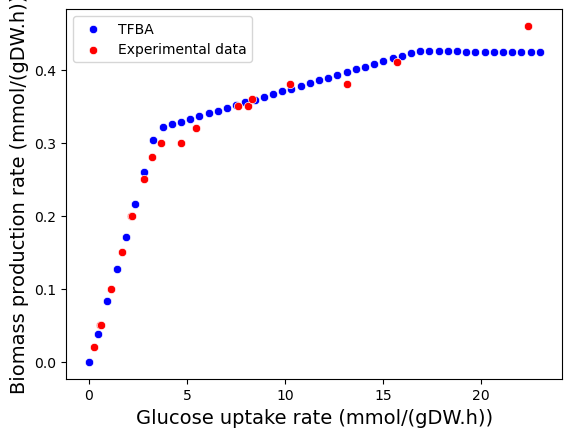

In [25]:
#plot biomass yield for stoichiometric model with balanced reactions and pH specified
df_data2 = pd.read_csv('plotting_Yeast_ALL_experimental_data.csv',index_col=0)
df_data2['regression'].fillna('Not fitted',inplace=True)
df_data2['regression'].replace('yes', 'Fitted', inplace=True)
df_data2.rename(columns={'regression':'Exp. data'}, inplace=True)
#rename index in Condition
df_data2.index.rename('Condition', inplace=True)

GUR_plot_range=[-x for x in GUR_range]
#plot biomass vs GUR in a scatter plot

sns.scatterplot(x=GUR_plot_range,y=fluxes_gdiss.loc['biomass_EX'],color='b',label='TFBA')
# sns.scatterplot(x=GUR_plot_range,y=tbiomass_flux,color='b',label='FBA and balanced')
# sns.scatterplot(x=GUR_plot_range,y=biomass_flux,color='g',label='FBA')
sns.scatterplot(x=df_data2['glc-D_EX'], y=df_data2['biomass_EX'], color=['red'],label='Experimental data')
plt.xlabel('Glucose uptake rate (mmol/(gDW.h))',fontsize=14)
plt.ylabel('Biomass production rate (mmol/(gDW.h))',fontsize=14)

plt.savefig('Figures/growth_all_TFBA_gdissconstraint.png',dpi=300)



<Axes: ylabel='EX_sbt__D_e'>

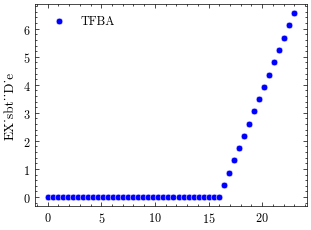

In [46]:
sns.scatterplot(x=GUR_plot_range,y=fluxes_gdiss.loc['EX_sbt__D_e'],color='b',label='TFBA')


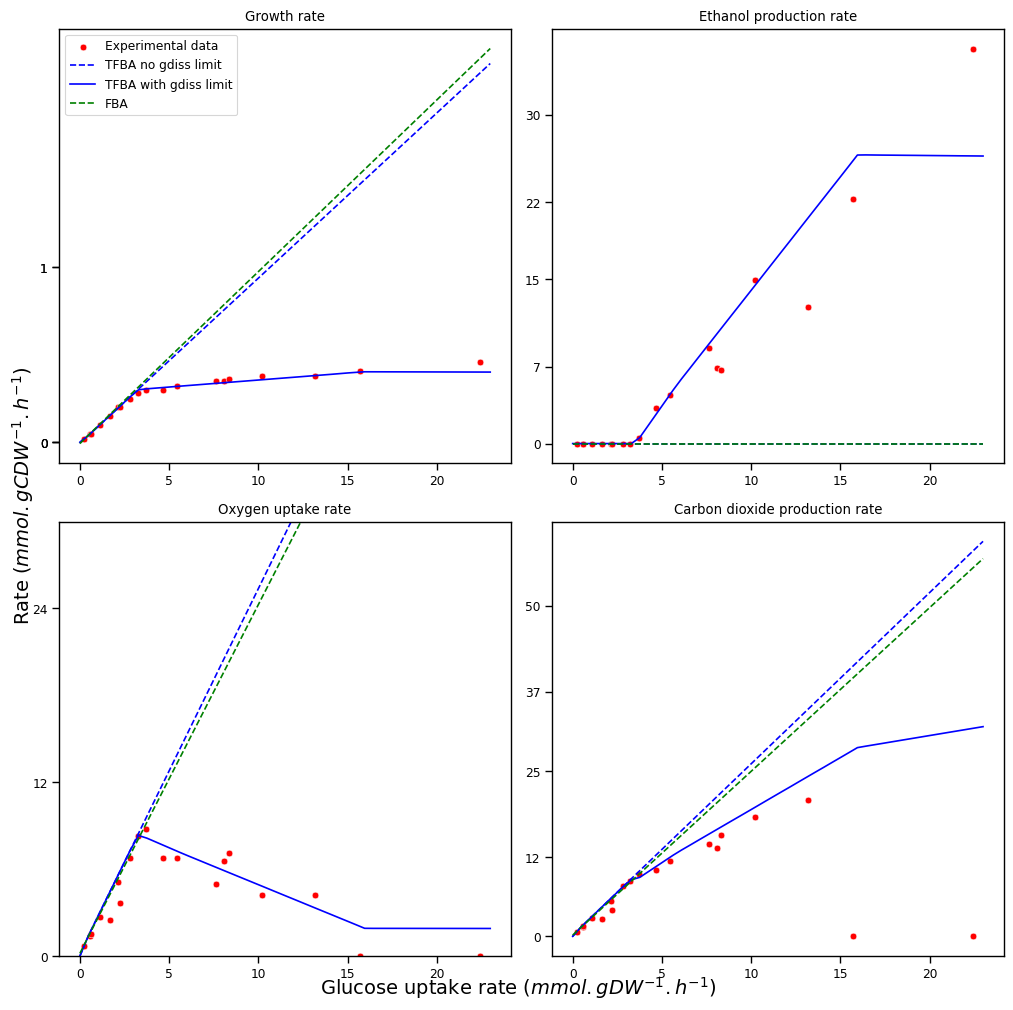

In [30]:
#set seaborn stype to paper
sns.set_context("paper")

#plot biomass yield for stoichiometric model with balanced reactions and pH specified
df_data2 = pd.read_csv('plotting_Yeast_ALL_experimental_data.csv',index_col=0)
df_data2['regression'].fillna('Not fitted',inplace=True)
df_data2['regression'].replace('yes', 'Fitted', inplace=True)
df_data2.rename(columns={'regression':'Exp. data'}, inplace=True)
#rename index in Condition
df_data2.index.rename('Condition', inplace=True)
df_data2.rename(columns={'co2tot_EX':'co2_EX'},inplace=True)
df_data2['o2_EX'].replace(np.nan, 0, inplace=True)
df_data2['co2_EX'].replace(np.nan, 0, inplace=True)
# 
fig,axes=plt.subplots(2,2,figsize=(10,10))
#GUR_range=[-0.25, -0.60,-1.10,-2.14, -4.67,-5.44,-7.62,-10.23,-13,-20]
#plot biomass vs GUR in a scatter plot
rxn_list=['biomass_EX','etoh_EX','o2_EX','co2_EX']
stoich=[1,1,-1,1]
rxn_titles=['Growth rate','Ethanol production rate','Oxygen uptake rate','Carbon dioxide production rate']
for i,ax in enumerate(fig.axes):
    if i<len(rxn_list):
        # sns.scatterplot(x=GUR_range,y=fluxes.loc[rxn_list[i]],color='b',label='TFBA')
        sns.scatterplot(x=df_data2['glc-D_EX'], y=df_data2[rxn_list[i]], ax=ax,color=['red'],label='Experimental data')
        ax.set_title(rxn_titles[i])
        sns.lineplot(x=GUR_plot_range,y=stoich[i]*fluxes.loc[rxn_list[i]],ax=ax,color='b',label='TFBA no gdiss limit',linestyle='--')
        sns.lineplot(x=GUR_plot_range,y=stoich[i]*fluxes_gdiss.loc[rxn_list[i]],ax=ax,color='b',label='TFBA with gdiss limit')
        sns.lineplot(x=GUR_plot_range,y=stoich[i]*fba_flux[rxn_list[i]],ax=ax,color='g',label='FBA',linestyle='--')
        # xmin,xmax= ax.get_xlim()
        # ax.set_xticks(np.arange(0,xmax,xmax/6))
        ymin,ymax=ax.get_ylim()
        
        # print(ymin,ymax,xmin,xmax)
        ax.set_yticks([int(i) for i in np.arange(0,ymax,ymax/5)])
        # ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        # ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.get_legend().remove()
        if i==0:
            ax.legend()

#for last subplot, change ylim
fig.axes[-2].set_ylim(0,30)
# plt.xlabel('Glucose uptake rate (mmol/(gDW.h))',fontsize=14)
# plt.ylabel('Biomass production rate (mmol/(gDW.h))',fontsize=14)


fig.text(0.5, 0.008 ,'Glucose uptake rate $(mmol.gDW^{-1}.h^{-1})$', ha='center', va='center',fontsize=14)
fig.text(0.005, 0.5, 'Rate $(mmol.gCDW^{-1}.h^{-1})$', ha='center', va='center',rotation='vertical',fontsize=14)
plt.tight_layout()
# plt.savefig('Figures/growth_all_TFBA_gdissconstraint.png',dpi=300)
# plt.savefig('Figures/growth_stoichio_only_&exp.png',dpi=300)
plt.savefig('Figures/all_plots.png',dpi=300)


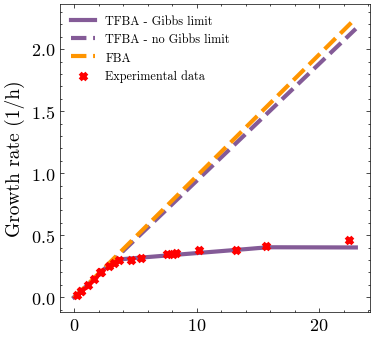

In [31]:
##with science plots
import scienceplots
#biomass
rxn='biomass_EX'
plt.style.use(['science','no-latex'])
fig = plt.gcf()
fig.set_size_inches(4,4)

plt.plot(GUR_plot_range,fluxes_gdiss.loc['biomass_EX'],color='#845B97',linewidth=3,label='TFBA - Gibbs limit')
plt.plot(GUR_plot_range,fluxes.loc['biomass_EX'],linestyle='--',color='#845B97',linewidth=3,label='TFBA - no Gibbs limit')
plt.plot(GUR_plot_range,fba_flux['biomass_EX'],linestyle='--',color='#FF9500',linewidth=3,label='FBA')

plt.scatter(df_data2['glc-D_EX'],df_data2['biomass_EX'],color='r',marker='x',linewidths=3, label='Experimental data',zorder=10)

# Set the tick labels inside the plot
plt.tick_params(axis='both', which='both', direction='in', labelsize=13)

# Add text in the upper left corner
# plt.text(0.95, 0.05, 'Growth rate', transform=plt.gca().transAxes, fontsize=14, verticalalignment='bottom', horizontalalignment='right')
plt.legend()
# plt.xlabel('Glucose uptake rate (mmol/(gDW.h))', fontsize=14)
plt.ylabel('Growth rate (1/h)', fontsize=14)

plt.savefig('Figures/biomass_plot.svg', dpi=300)


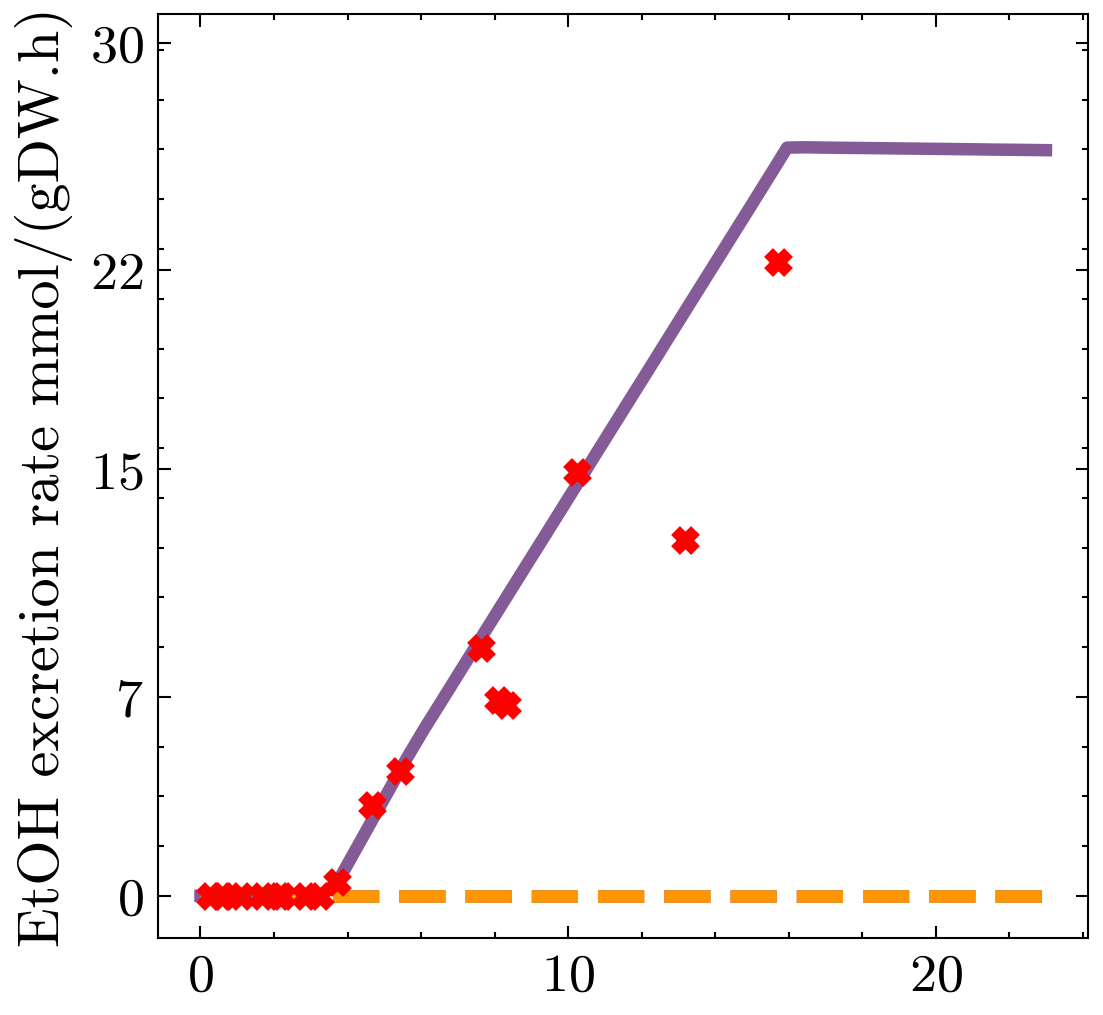

In [32]:
rxn='etoh_EX'
plt.style.use(['science','no-latex'])
plt.figure(dpi=300)

fig = plt.gcf()
fig.set_size_inches(4,4)

plt.plot(GUR_plot_range,fluxes_gdiss.loc[rxn],color='#845B97',linewidth=3)
plt.plot(GUR_plot_range,fluxes.loc[rxn],linestyle='--',color='#845B97',linewidth=3)
plt.plot(GUR_plot_range,fba_flux[rxn],linestyle='--',color='#FF9500',linewidth=3)

plt.scatter(df_data2['glc-D_EX'],df_data2[rxn],color='r',marker='x',linewidths=3, zorder=10)
ax=plt.gca()
ymax=30
ax.set_ylim(-1.5,31)
plt.yticks([int(i) for i in np.arange(0,ymax+1,ymax/4)])
# plt.xlabel('Glucose uptake rate (mmol/(gDW.h))', fontsize=14)
# plt.ylabel('Growth rate (mmol/(gDW.h))', fontsize=14)

# Set the tick labels inside the plot
plt.tick_params(axis='both', which='both', direction='in', labelsize=13)
# plt.text(0.1, 0.95, 'Ethanol production rate', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
plt.ylabel('EtOH excretion rate mmol/(gDW.h)', fontsize=14)

plt.savefig('Figures/etoh_plot.svg', dpi=300)



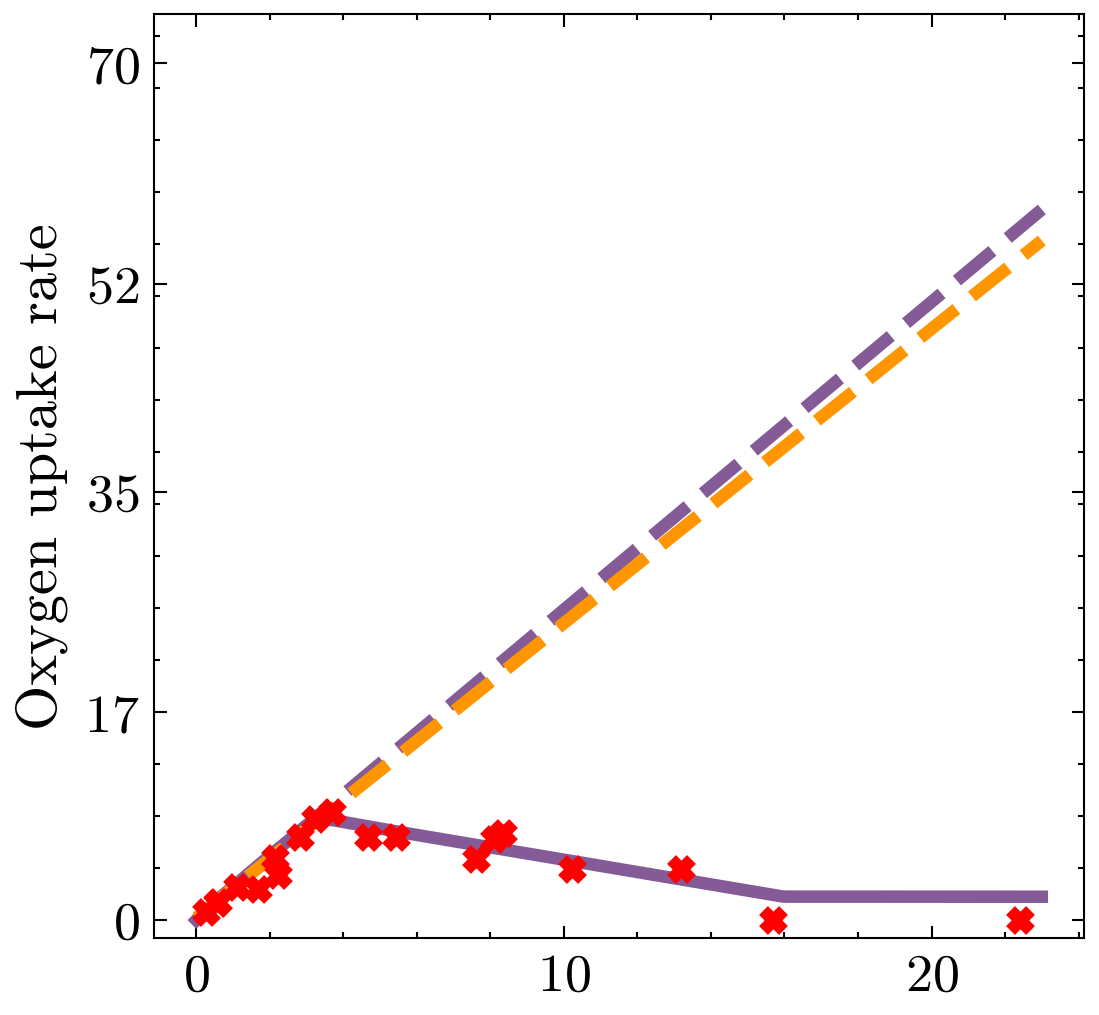

In [33]:
rxn='o2_EX'
plt.style.use(['science','no-latex'])
plt.figure(dpi=300)

fig = plt.gcf()
fig.set_size_inches(4,4)

plt.plot(GUR_plot_range,-1*fluxes_gdiss.loc[rxn],color='#845B97',linewidth=3)
plt.plot(GUR_plot_range,-1*fluxes.loc[rxn],linestyle='--',color='#845B97',linewidth=3)
plt.plot(GUR_plot_range,-1*fba_flux[rxn],linestyle='--',color='#FF9500',linewidth=3)

plt.scatter(df_data2['glc-D_EX'],df_data2[rxn],color='r',marker='x',linewidths=3, zorder=10)
ax=plt.gca()
ymin,ymax=ax.get_ylim()
plt.yticks([int(i) for i in np.arange(0,71,70/4)])

ax.set_ylim(-1.5,74)
# Set the tick labels inside the plot
plt.tick_params(axis='both', which='both', direction='in', labelsize=13)
# plt.text(0.1, 0.95, 'Oxygen uptake rate', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
plt.ylabel('Oxygen uptake rate', fontsize=14)

plt.savefig('Figures/o2_plot.svg', dpi=300)


KeyError: 'co2tot_EX'

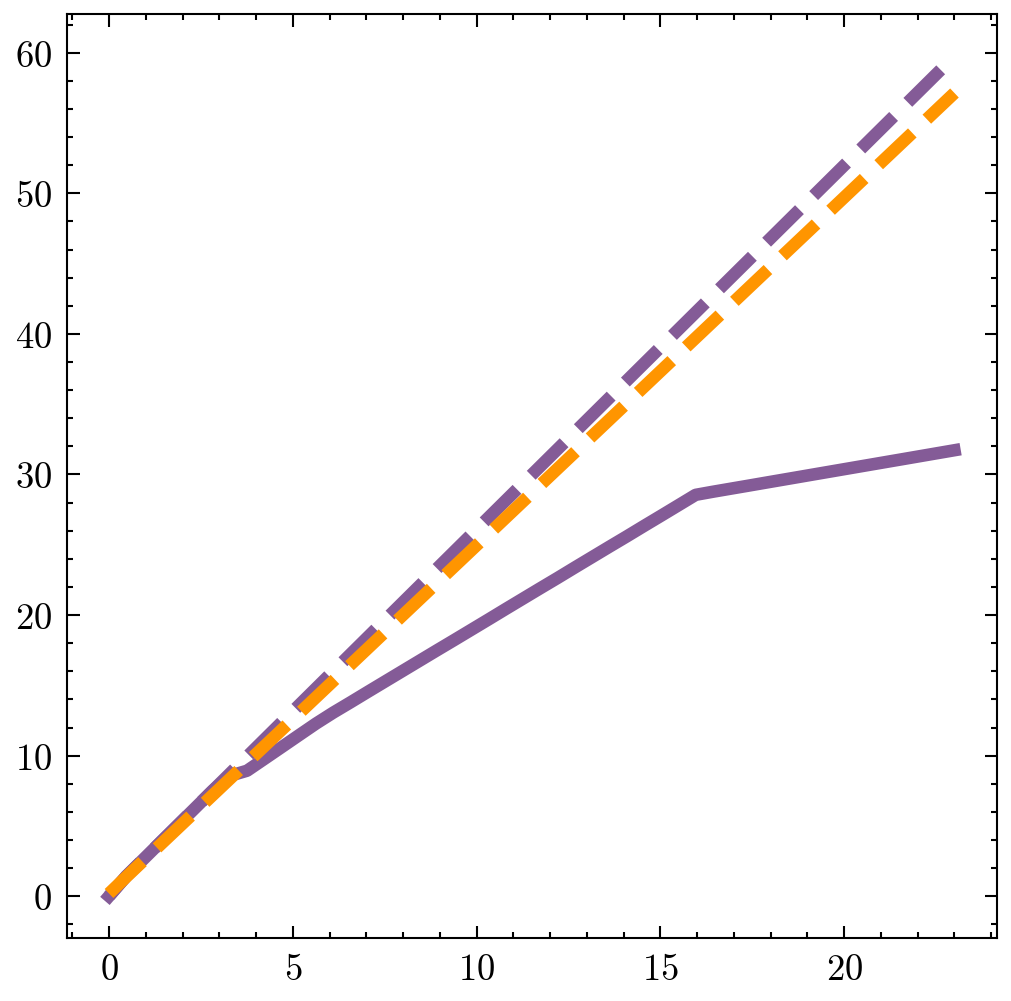

In [34]:
rxn='co2_EX'
plt.style.use(['science','no-latex'])
plt.figure(dpi=300)

fig = plt.gcf()
fig.set_size_inches(4,4)

plt.plot(GUR_plot_range,1*fluxes_gdiss.loc[rxn],color='#845B97',linewidth=3)
plt.plot(GUR_plot_range,1*fluxes.loc[rxn],linestyle='--',color='#845B97',linewidth=3)
plt.plot(GUR_plot_range,1*fba_flux[rxn],linestyle='--',color='#FF9500',linewidth=3)

plt.scatter(df_data2['glc-D_EX'],df_data2['co2tot_EX'],color='r',marker='x',linewidths=3, zorder=10)
ax=plt.gca()
ymin,ymax=ax.get_ylim()
plt.yticks([int(i) for i in np.arange(0,71,70/4)])
ax.set_ylim(-1.5,74)

# ax.set_ylim(-1.5,74)
# Set the tick labels inside the plot
plt.tick_params(axis='both', which='both', direction='in', labelsize=13)
# plt.text(0.1, 0.95, 'CO2 production rate', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
plt.ylabel('CO2 excretion rate', fontsize=14)
plt.savefig('Figures/co2_plot.svg', dpi=300)
